In [10]:
from dotenv import load_dotenv
import swifter
import os

_ = load_dotenv()

## Quickly Checking if Jobs dataset columns look alright

In [11]:
from google.cloud import bigquery
client = bigquery.Client()

In [12]:
DATASET_NAME = os.getenv("DATASET_NAME")
TABLE_NAME = os.getenv("TABLE_NAME")

In [13]:
table = client.get_table(f"{client.project}.{DATASET_NAME}.{TABLE_NAME}")

In [14]:
column_names = [schema.name for schema in table.schema]

In [15]:
column_queries = [f'countif({column} is not null) as {column}_count'for column in column_names]
query = f''' 
    SELECT {', '.join(column_queries)}
    FROM `linkedin-jobs-401018.static_job_warehouse.jobs`
'''

query_job = client.query(query)  # Make an API request.

# for row in query_job:
#     print("{}: \t{}".format(row.word, row.word_count))

In [16]:
rows = query_job.result()

In [17]:
column_counts = rows.to_dataframe()

In [18]:
column_counts

,job_id_count,title_count,company_count,description_count,onsite_remote_count,location_count,posted_date_count,country_count,seniority_level_count,employment_type_count,job_function_count,industries_count,salary_lb_count,salary_ub_count,salary_text_count
0,5618,5618,5618,5541,5618,5618,5618,5618,3841,5527,5241,5239,965,965,965


Column counts look good

## Uncover Relationships between Variables using Entropy

In [2]:
import math
import pandas as pd
import numpy as np

In [3]:
df_sample = pd.DataFrame({"A" : [i for i in range(1, 100)]})

### Relationship between Entropy and Number of Distinct Values in a Dataset

In [4]:
def get_entropy(list_of_counts, level=1):
    list_of_counts = list_of_counts.sort_index()
    if level == 1:      
        n = sum(list_of_counts)
        list_of_probabilities = list_of_counts / n
        return sum(-p * math.log(p, 2) for p in list_of_probabilities)
    else:
        all_indices = list_of_counts.droplevel(level - 1).index.unique()
        # Check entropy based on previous level group, so see whether adding the new column improves (minimizes) overall entropy
        all_counts = [list_of_counts.loc[indice] for indice in all_indices]
        weighted_average_arr = []
        for count in all_counts:
            n = sum(count)
            list_of_probabilities = count / n
            weighted_average_arr.append(sum(-p * math.log(p, 2) for p in list_of_probabilities))
            
        return np.mean(weighted_average_arr)


def get_groups_over_90(list_of_counts, level=1):
    list_of_counts = list_of_counts.sort_index()
    if level == 1:      
        n = sum(list_of_counts)
        list_of_probabilities = list_of_counts / n
        return round(int(max(list_of_probabilities) >= 0.9) * 100, 2)
    else:
        all_indices = list_of_counts.droplevel(level - 1).index.unique()
        all_counts = [list_of_counts.loc[indice] for indice in all_indices]
        max_90_counter = 0
        for count in all_counts:
            n = sum(count)
            list_of_probabilities = count / n
            if max(list_of_probabilities) >= 0.9:
                max_90_counter += 1
            
        return round(max_90_counter / len(all_counts) * 100, 2)


                

In [5]:
def entropy_relationship():
    records = []
    for i in range(1, 1000):
        df_sample = pd.DataFrame({"A" : [j for j in range(1, i+1)]})
        value = get_entropy(df_sample["A"].value_counts())
        records.append([value])
    
    return pd.DataFrame(records, columns=["entropy"], index=range(1, 1000))


In [6]:
df_entro_rel = entropy_relationship()

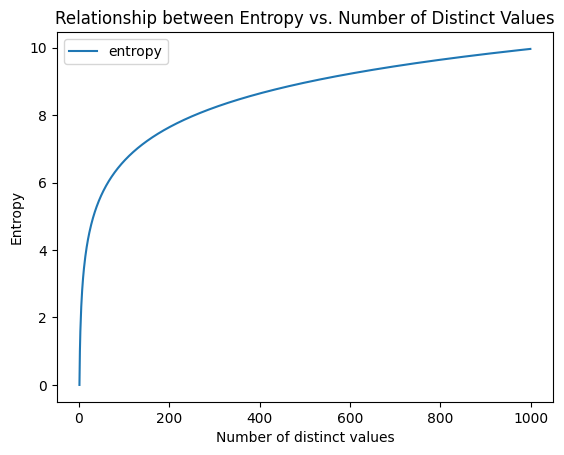

In [7]:
ax = df_entro_rel.plot(xlabel="Number of distinct values", ylabel="Entropy", title="Relationship between Entropy vs. Number of Distinct Values")
_ = ax.plot()

### Load DataFrame

We will uncover relationships in the jobs dataset

In [19]:
query_job = client.query('''
    SELECT *
    FROM `linkedin-jobs-401018.static_job_warehouse.jobs`        
''')

In [20]:
rows = query_job.result()

In [21]:
df = rows.to_dataframe()

In [22]:
df.columns

Index(['job_id', 'title', 'company', 'description', 'onsite_remote',
       'location', 'posted_date', 'country', 'seniority_level',
       'employment_type', 'job_function', 'industries', 'salary_lb',
       'salary_ub', 'salary_text'],
      dtype='object')

### Write Relationship-Uncovering Entropy Functions

In [23]:
from itertools import permutations
df_entropy_columns = ["title", "company", "onsite_remote", "seniority_level", "employment_type", "posted_date",
                      "job_function", "industries", "country", "location"] 
def get_entropy_table(df, entropy_columns, levels=2):
    '''
        This function is designed to uncover relationships
        between nominal and ordinal variables. Numeric relationships should be uncovered using
        correlation instead.

        df: pd.DataFrame
        entropy_columns: subset of columns to use from df. Use entropy_columns to filter for only nominal/ordinal variables
        levels: depth of relationships. Relationships will be generated on `levels` columns
    '''
    MAX = len(df)
    df_entropy = df.copy()
    final_df = None
    for i in range(levels, levels-1, -1):
        all_perms = list(permutations(entropy_columns, r=i))
        entropies = []
        for perm in all_perms:
            get_counts = df_entropy.loc[:, perm].value_counts()
            get_counts = get_counts[get_counts > 1]
            entropies.append((
                get_entropy(get_counts, level=i),
                get_groups_over_90(get_counts, level=i)
            ))
        
        final_df = pd.DataFrame(
            entropies,
            columns=[f"entropy", f"percent_groups_over_90"], 
            index=pd.MultiIndex.from_tuples(all_perms)
        )
    #         level_array = [j for j in range(0, i)]
    #         final_df[f"level_{i}"] = (
    #             final_df.groupby(level=level_array)
    #                     .transform(
    #                         lambda x: get_entropy(
    #                             df_entropy.loc[:, [x.index.get_level_values(k).unique()[0] for k in level_array]].value_counts(),
    #                             level=i
    #                         )           
    #                     )[f"level_{i+1}"]
    #         )

    #         final_df[f"percent_groups_over_90_level_{i}"] = (
    #             final_df.groupby(level=level_array)
    #                     .transform(
    #                         lambda x: get_groups_over_90(
    #                             df_entropy.loc[:, [x.index.get_level_values(k).unique()[0] for k in level_array]].value_counts(),
    #                             level=i
    #                         )           
    #                     )[f"percent_groups_over_90_level_{i+1}"]
    #         )

    #         # final_df[f"ratio_of_one_counts_level_{i}"] = (
    #         #     final_df.groupby(level=level_array)
    #         #             .transform(
    #         #                 lambda x: sum(
    #         #                     df_entropy.loc[:, [x.index.get_level_values(k).unique()[0] for k in level_array]].value_counts() == 1
    #         #                 )/len(df_entropy.loc[:, [x.index.get_level_values(k).unique()[0] for k in level_array]].value_counts())
    #         #             )[f"level_{i+1}"]
    #         # )
    #         # final_df[f"level_{i}_distinct_count"] = (
    #         #     final_df.groupby(level=level_array)
    #         #             .transform(
    #         #                 lambda x: len(
    #         #                     df_entropy.loc[:, [x.index.get_level_values(k).unique()[0] for k in level_array]].value_counts()      
    #         #                 )
    #         #             )[f"level_{i+1}"]
    #         # )
        
    # for i in range(2, levels + 1):
    #     final_df[f"diff_level_{i}"] = (final_df[f"level_{i}"] - final_df[f"level_{i-1}"])

    # level_names = [f"level_{i}" for i in range(1, levels + 1)]
    # groups_over_90_names = [f"percent_groups_over_90_level_{i}" for i in range(1, levels + 1)]
    return final_df
    # return final_df[final_df.columns.reindex(level_names + groups_over_90_names + diff_names)[0]]



In [24]:
df_distinct_count = pd.DataFrame([[i, len(df[i].unique())] for i in df.columns], columns=["Column", "num_distinct_values"])
    

In [25]:
final_table_2 = get_entropy_table(df, df_entropy_columns, levels=2)

In [26]:
final_table_2.sort_values("entropy")

entropy  percent_groups_over_90
location        country        0.000000                  100.00
company         country        0.014341                   99.00
title           country        0.014391                   98.92
company         onsite_remote  0.020687                   98.49
                posted_date    0.057631                   94.87
...                                 ...                     ...
country         industries     4.907526                    0.00
onsite_remote   company        5.388194                    0.00
seniority_level company        5.916110                    0.00
country         company        5.954222                    0.00
employment_type company        6.216356                    0.00

[90 rows x 2 columns]

### Seriously... What is Entropy? What is Percent Groups over 90?

Let's explain using examples

First of all, let's understand what entropy is. 

Second of all, let's understand how my algorithm finds insights using entropy.
Then we'll be able to understand both Entropy and Percent Groups over 90

### 1 -- Understanding Entropy

In [384]:
example_df = pd.DataFrame({"A" : [1]})
example_df.value_counts() / len(example_df)

A
1    1.0
dtype: float64

In [36]:
get_entropy(example_df.value_counts())

0.0

entropy  = 
`
sum(-p * log(p, 2) for p in proportions)` (log base 2), 
where proportions represents every unique group of a sample and always sums to one. 

Entropy is a measure of randomness on a dataset, and an entropy of 0 means that our dataset only contains one distinct value, whereas a higher entropy means we have many distinct values. 

Thus if we only have one distinct value in the sample, we only have one distinct value with a proportion of 1 in the dataset, meaning entropy is 0

`sum(-1 * log(1, 2)) = 0`

In [38]:
example_df = pd.DataFrame({"A" : [1, 2]})
example_df.value_counts() / len(example_df)

A
1    0.5
2    0.5
dtype: float64

In [39]:
get_entropy(example_df.value_counts())

1.0

For our new sample,

`sum(-p * log(p, 2) for p in proportions)` = 

`-0.5 * log(0.5, 2) - 0.5 * log(0.5, 2) =`

`-0.5 * (-1) - 0.5 * (-1) =` 

`0.5 - (-0.5) = 1`

Entropy increases with more distinct values, and as we see in the earlier plot, increase is logarithmic ASSUMING that our distinct values are uniformally distributed (uniform pdf). I will plot the chart here again for reference

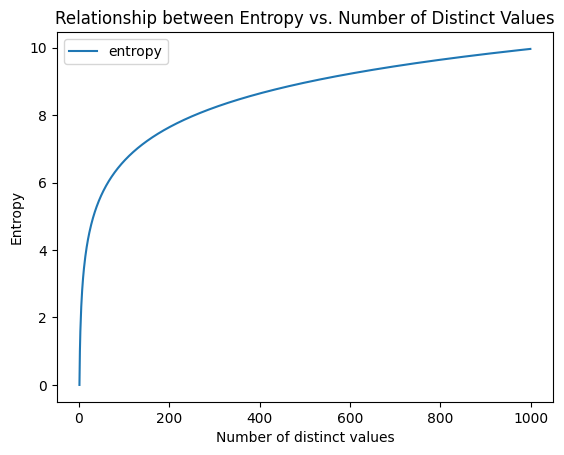

In [159]:
ax = df_entro_rel.plot(xlabel="Number of distinct values", ylabel="Entropy", title="Relationship between Entropy vs. Number of Distinct Values")
_ = ax.plot()

### 2 -- How is entropy calculated based on level? What is our goal 

Once again let's check an example, this time on our actual dataset. Check out the distribution of our location column

In [370]:
df[["location"]].value_counts()

location                       
Toronto, Ontario, Canada           981
United States                      632
Mississauga, Ontario, Canada       401
Canada                             366
New York City Metropolitan Area    179
                                  ... 
Alpharetta, GA                       1
Maryland, United States              1
Los Angeles, CA                      1
Knoxville, TN                        1
Woodcliff Lake, NJ                   1
Length: 148, dtype: int64

In [371]:
get_entropy(df[["location"]].value_counts(), level=1)

5.3315499601073535

There are many locations in the world so entropy is relatively big, whereas if you took the entropy of the *country* column, we'd get an entropy of ~1 since the distribution of number of USA and Canada jobs is ~50/50


In [372]:
df[["country"]].value_counts()

country
USA        2845
Canada     2773
dtype: int64

In [373]:
get_entropy(df[["country"]].value_counts(), level=1)

0.9998815164779034

Ok great. We can calculate entropy over one column. But that is not enough draw meaningful insight.

How do we find useful information from entropy? 

<h3>**Idea:**</h3>
If you think about it, calculating entropy over one column gives you a measure of how "random" that column's distribution is.

Now what if you calculated entropy over groups? What about calculating the entropy of employment types (e.g. Full-Time, Contract) over industry groups (in SQL lingo, group by industry)? There's not much meaning if entropy is always high in the industry groups, you'd just have many different types of Full-Time, Contract, and Hybrid jobs for each industry.

But what if the entropy is always low in every industry group? For example, healthcare industry offers full-time work most of the time, whereas advertising industry only offers contract jobs. If the entropy for an attribute is always low across multiple groups, we end up getting a **relationship** between the attribute and the group, or in this case, between industries and employment type

<h3>**Thus, Our Action Plan:** Find the entropy of an attribute for specific **groups.** Then calculate the mean of entropies across all groups</h3>

**If mean entropy is high, each group contains attributes of different values. If mean entropy is low, each group contains attribute with very few or only one value.**

So let's say we have groups of locations. And we want to find out the relationship between country and location

From our common sense, we know that countries are unique to each location.

So... if we calculated entropy of the **country attribute** for each location, we should always get 0, right? Since each location contains only one country attribute

In [392]:
# value count of jobs by location and country
df[["location", "country"]].value_counts(sort=False)

location                    country
Alberta, Canada             Canada      1
Alpharetta, GA              USA         1
Ancaster, Ontario, Canada   Canada     37
Ann Arbor, MI               USA        12
Annapolis, MD               USA        20
                                       ..
Waterloo, Ontario, Canada   Canada     37
Wilmington, DE              USA        22
Winnipeg, Manitoba, Canada  Canada      1
Wisconsin, United States    USA        21
Woodcliff Lake, NJ          USA         1
Length: 148, dtype: int64

For example, we find the entropy of location group: Alberta, Canada, which only has one country attribute Canada. So its entropy is zero. 

We find the entropy of Alpharetta, GA, which is **also zero** since it corresponds to only one country attribute: USA. 

Ancaster, Ontario, Canada has an entropy of **zero** even though there are many jobs in that location, but all those jobs are happening in Canada.

Let's return the entropy table for location and country to see what the entropies are
 

In [391]:
get_entropy_table(df, ["location", "country"], levels=2)

,,entropy,percent_groups_over_90
location,country,0.00000,100.0
country,location,4.25661,0.0


In the entropy table, for every location group, we find the entropy of the country column. We take the average of entropy across all locations and get an average entropy of 0. 

This means that we have a found a relationship: **each location group has only one unique country attribute**, since every location received an entropy of zero on the country column. 

**But BE AWARE that each country group can have multiple location attributes**, since every country can have multiple locations across the country, which means calculating the mean of location entropies over every country would produce a much higher value. Don't flip the relationships by accident.

Finding of relationship between location and country is trivial at best, but I think it is a great "common-sense" way to explain the potential of using entropy to uncover more complex relationships between columns in **ANY Dataset**!!



Now let me quickly cover *percent_groups_over_90*, a column that calculates the percentage of groups that have an attribute which makes up for 90% of the group proportion.
Let's see an example

In [405]:
example_df = pd.DataFrame({"a" : [1,1,1,1,1,1,1,1,1,2,1,1,2,2,2], "b":[1,1,1,1,1,1,1,1,1,1,2,2,2,2,2]})

In [406]:
example_df[["b", "a"]].value_counts(sort=False)

b  a
1  1    9
   2    1
2  1    2
   2    3
dtype: int64

In [413]:
example_table = get_entropy_table(example_df, ["b", "a"])

In the example table, we get a percent_groups_over_90 of 50%. Notice that we are calculating values based on attribute "a" for groups in "b".

For group b == 1, the max proportion found for attribute "a", "a" == 1, makes up for 90% of the group proportion.So it is considered as a group that has a proportion >= 90%.

For group b == 2, the max proportion found for attribute "a", "a" == 2, makes up for 3/5 or 60% of the group proportion. So it is not considered as a group that has a proportion >= 60%. 

Thus, the percent_groups_over_90, in layman's terms, percent of groups with an attribute that makes up for >= 90% of the group proportion, is 50%. Since 1 out of 2 groups qualify for the criteria. 

In [415]:
example_table.loc[("b", "a")]

entropy                    0.485475
percent_groups_over_90    50.000000
Name: (b, a), dtype: float64

The only reason we calculate percent_groups_over_90 is to provide a similar alternative calculation to entropy, which normal people, and myself included, are more familiar with rather than a logarithmic entropy calculation.

Higher percentage means less entropy, lower percentage means more entropy,

as we can see in a line plot comparing percent and entropy in line chart

In [417]:
px.line(final_table_2.sort_values("entropy"), x="entropy", y="percent_groups_over_90")

Let's cover more jobs dataset insights using entropy!!

### 3 -- Interpreting Entropy

In [307]:
plt.Normalize(0,1)

Since we already know that low entropy between two variables implies one-to-one relationship, we can plot a network graph representing relationships between one variable and every other variable

In [236]:
import re
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network
from collections import defaultdict

In [328]:
def generate_network_from_df(df):
    network = nx.from_pandas_edgelist(df,source='level_0',target='level_1', edge_attr=True, create_using=nx.DiGraph(),)
    return network

def plot_network_graph(network, ax, variable, use_colorscale=False):
    
    # Create a colormap for diverging colors
    colormap = plt.get_cmap("coolwarm")
    
    ## Add Colorscale (if use_colorscale is true)
    if use_colorscale:
        sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(0, 100))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax)
    
    # Extract edge weights
    edge_weights = [d["percent_groups_over_90"] for u, v, d in network.edges(data=True)]

    # Normalize edge weights to [0, 100]
    min_weight = min(edge_weights)
    max_weight = max(edge_weights)
    normed_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in edge_weights]

    # Draw the graph with edge colors based on the colormap
    pos = nx.spring_layout(network)
    
    # Draw nodes
    nx.draw_networkx_nodes(network, pos, node_color="lightgray", node_size=13000, ax=ax)
    edges = nx.draw_networkx_edges(
        G,
        pos,
        edgelist=network.edges(),
        edge_cmap=colormap,
        edge_vmin=0,
        edge_vmax=1,
        edge_color=normed_weights,
        width=2,
        arrows=True,
        connectionstyle=f'arc3, rad = {0.05}',
        node_size=13000,
        arrowsize=10,
        ax=ax
    )
        

    # Add labels to nodes
    labels = {node: node for node in network.nodes()}
    nx.draw_networkx_labels(network, pos, labels, font_size=12, ax=ax)

   

    
    # Set axis limits and display the plot
    ax.set_xlim(-1.4, 1.4)
    ax.set_ylim(-1.4, 1.4)
    ax.axis("off")         
    ax.set_title(f"Relation of {variable} with other Variables",
            fontsize=16)


Create a network graph representing relationships between one variable vs. every other variable,
for every variable

In [321]:
final_table_2_reset = final_table_2.reset_index()


In [322]:
import math

Text(0.6, -1.35, 'Colorscale represents percent_groups_over_90.\nThe higher the percentage, the lower the entropy')

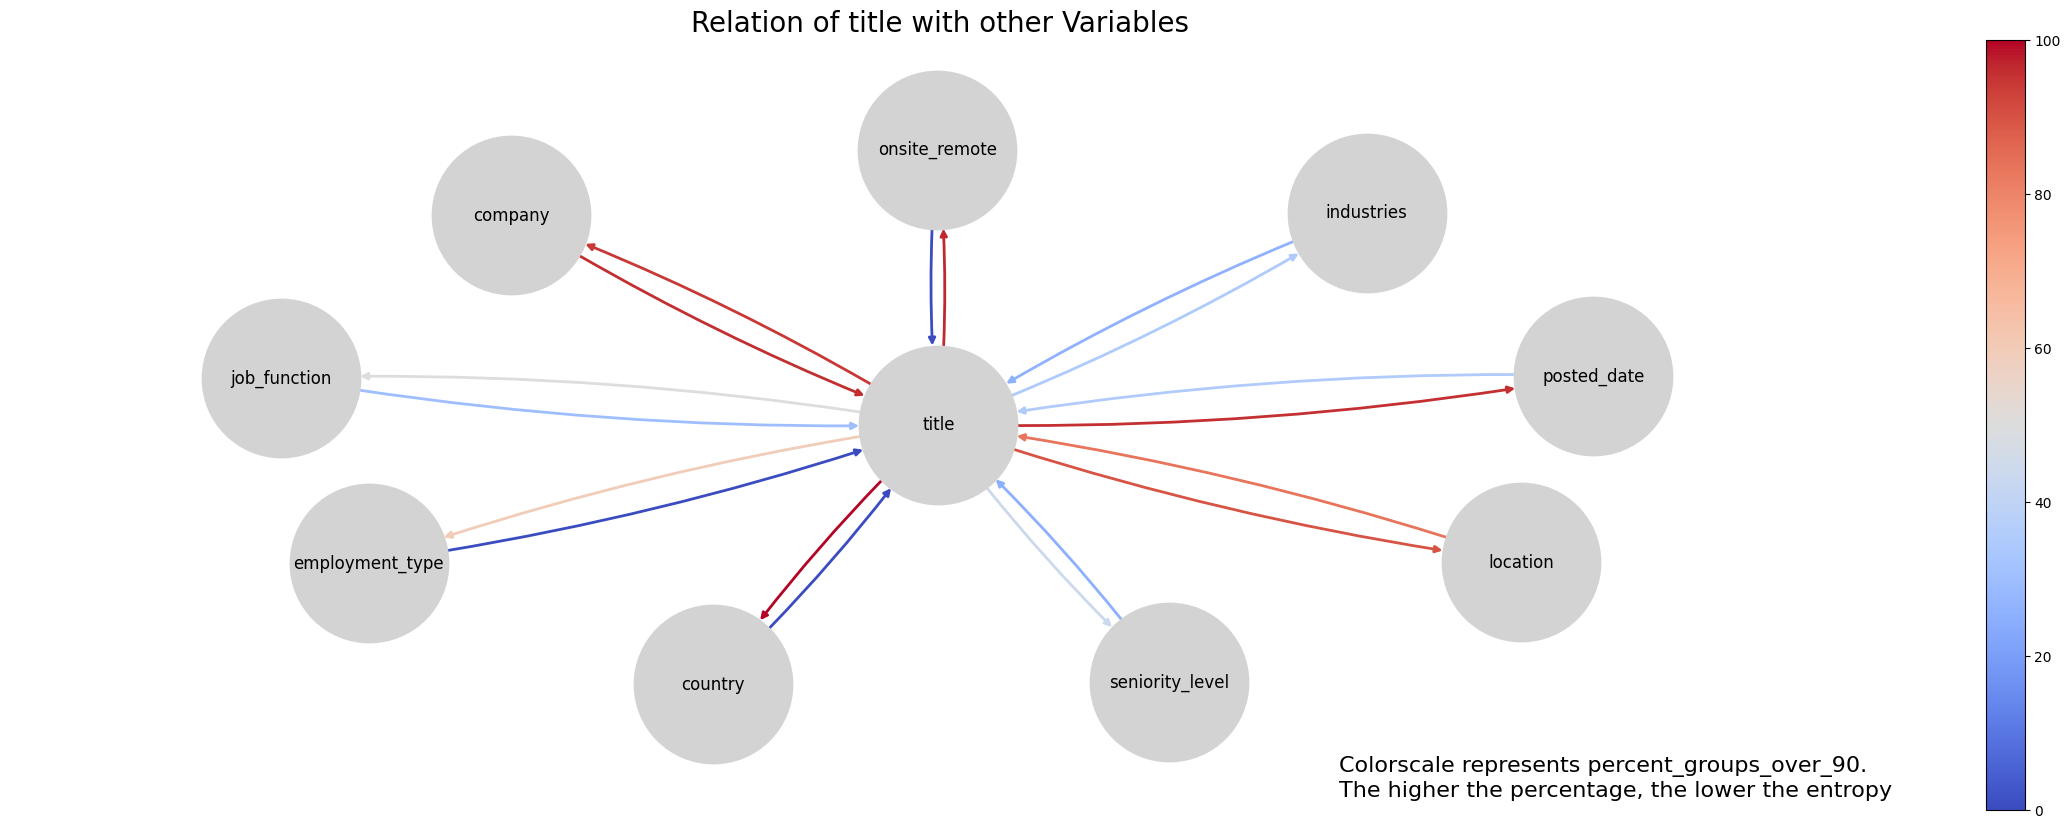

In [335]:
COLUMN = "title"
fig, ax = plt.subplots(figsize=(30, 10))
final_table_2_one_variable = final_table_2_reset[(
    network_table['level_0'] == COLUMN) |
    (network_table['level_1'] == COLUMN)
]

network = generate_network_from_df(final_table_2_one_variable)
plot_network_graph(network, ax, variable=COLUMN, use_colorscale=True)
_ = ax.text(x=0.6, y=-1.35, s="Colorscale represents percent_groups_over_90.\nThe higher the percentage, the lower the entropy", fontsize=16)


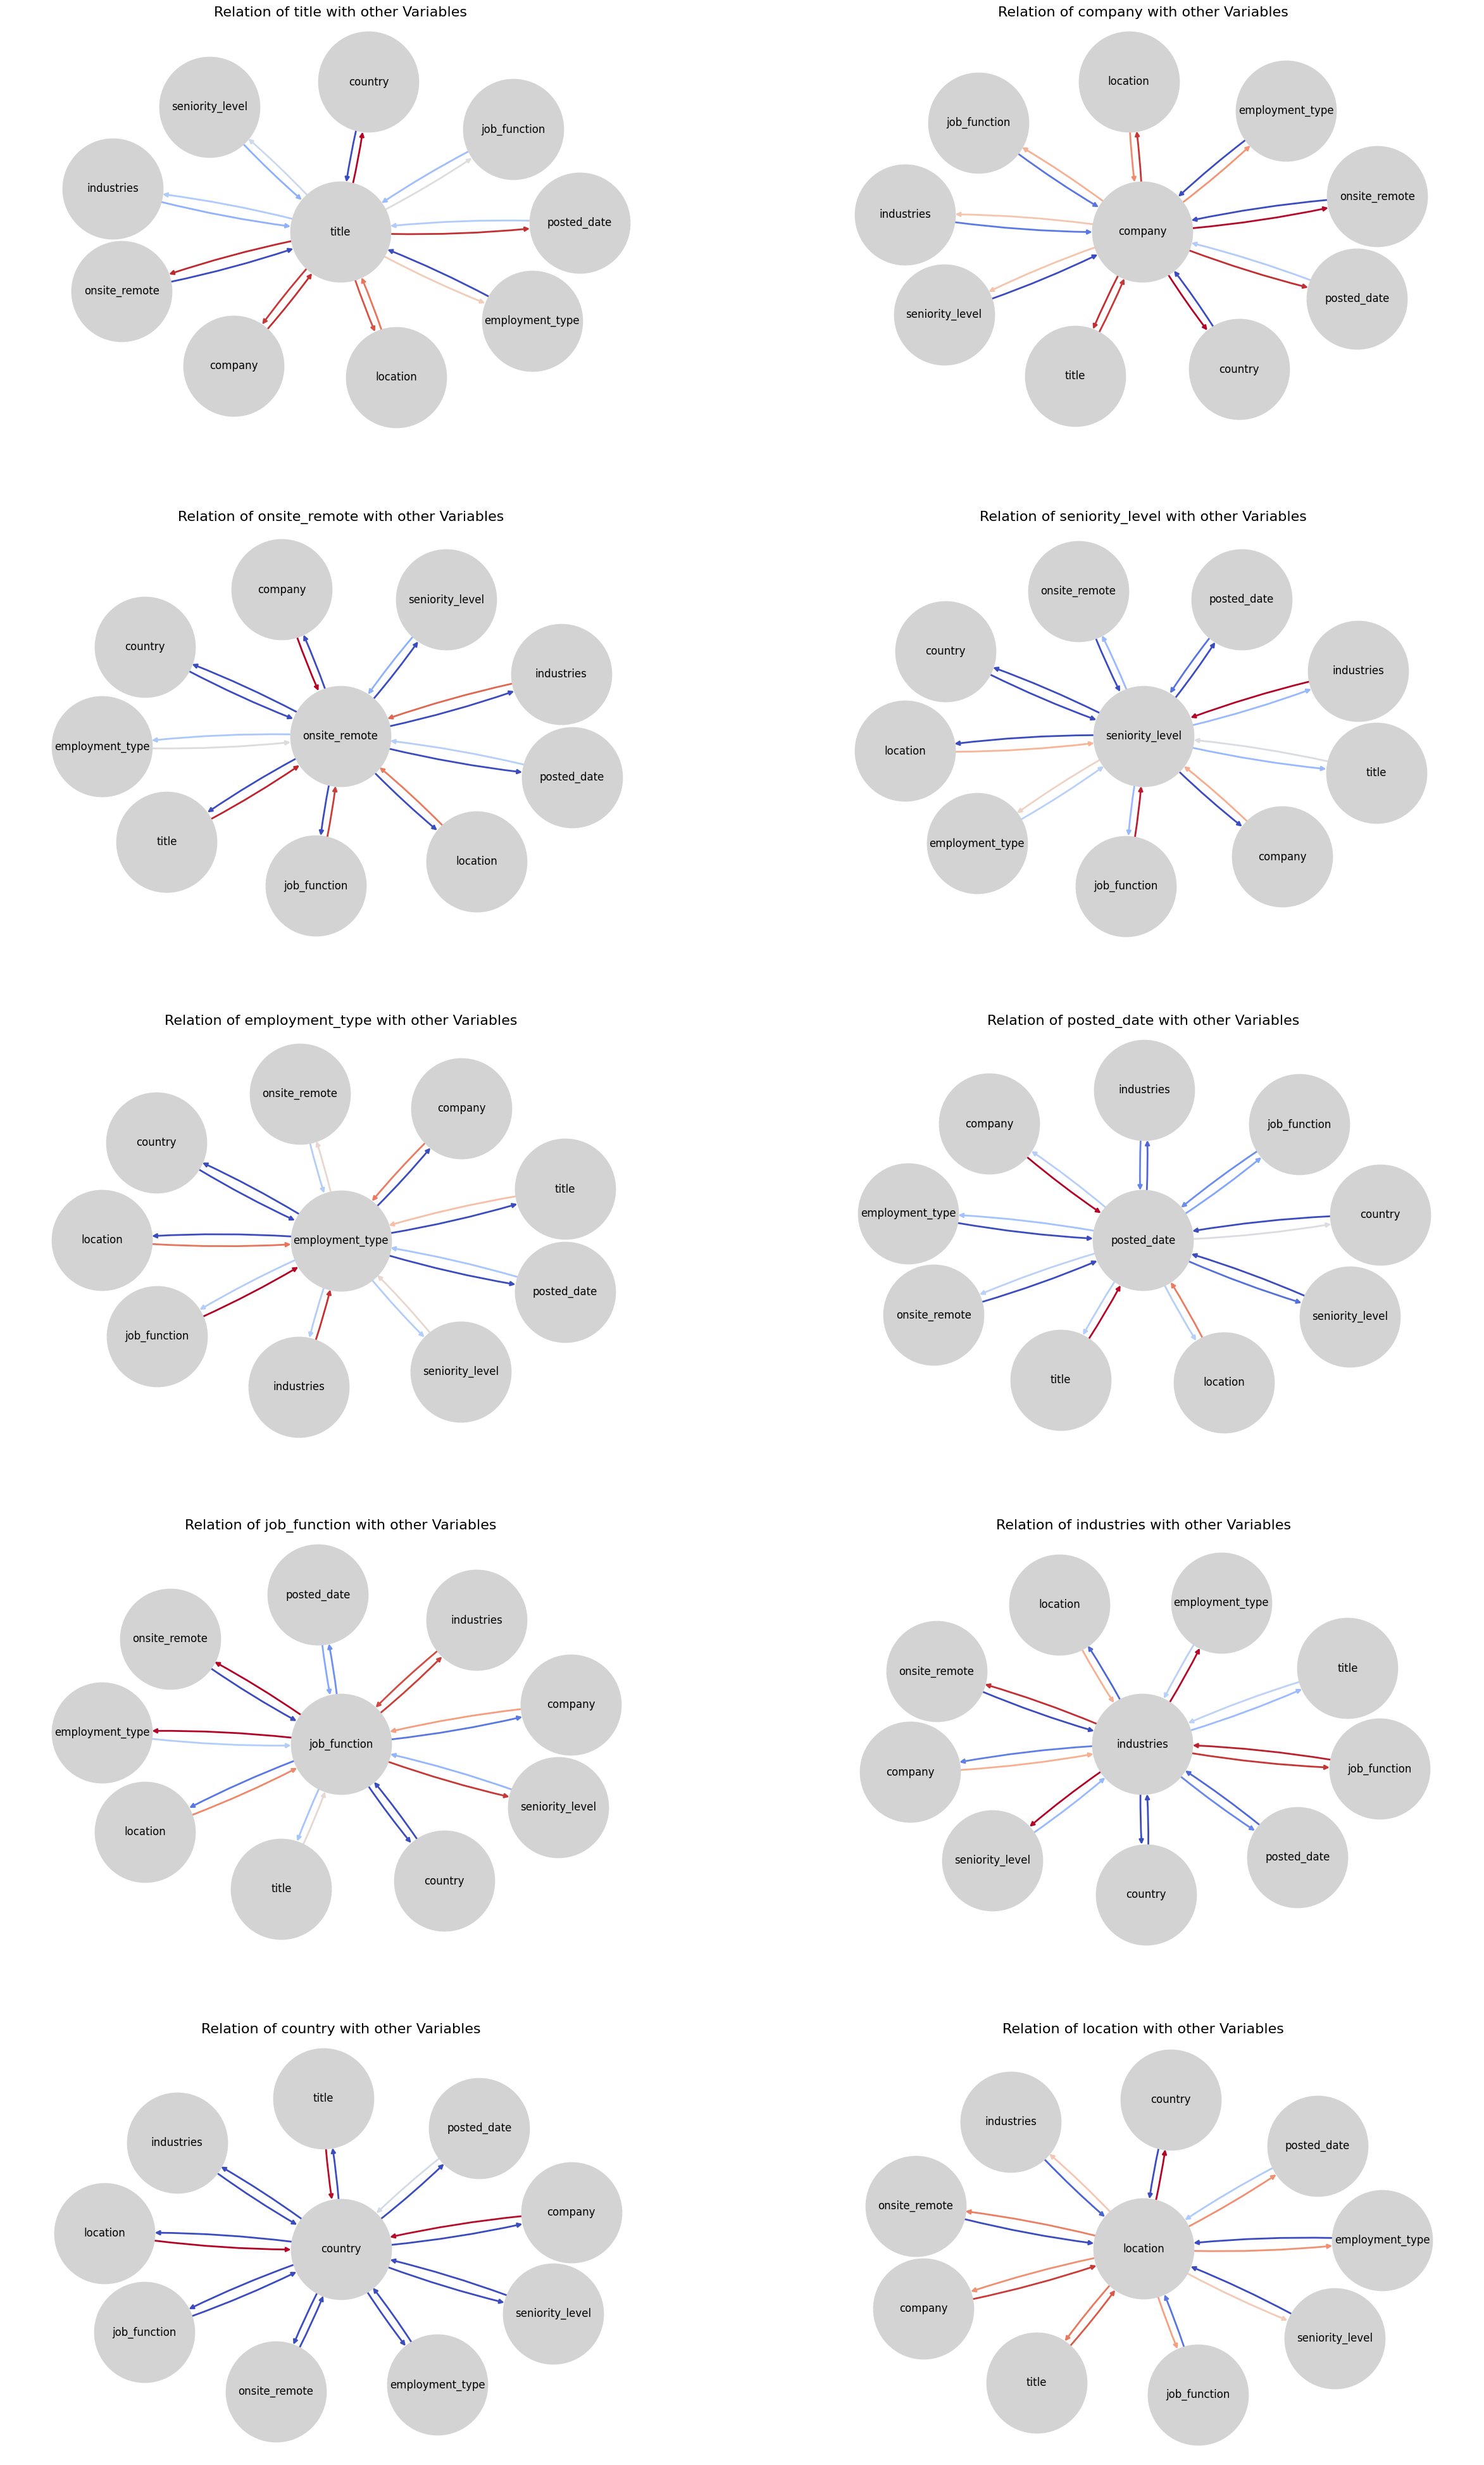

In [326]:
n = len(final_table_2_reset['level_0'].unique())


fig, axes = plt.subplots(math.ceil(n // 2), 2, figsize=(30, 50))
indices = [(i, j) for i in range(n // 2 + 1) for j in range(2)]
for i, column in enumerate(final_table_2_reset["level_0"].unique()):
    final_table_2_one_variable = final_table_2_reset[(
        network_table['level_0'] == column) |
        (network_table['level_1'] == column)
    ]

    network = generate_network_from_df(final_table_2_one_variable)
    plot_network_graph(network, axes[indices[i]], variable=column)

# Create a colorbar
# sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(0, 1))
# sm.set_array([])
# cbar = fig.colorbar(sm)
# plt.suptitle('Relationships between variable',fontsize=24)




In [ ]:
%run ./PlotLee_Mini/setup_notebook.ipynb

In [120]:
import plotly.express as px
import plotly.io as pio
px.defaults.template = "bnw"

In [353]:
def plot_groups(df, groups):
    '''
        Check the max proportion that the second last level contains. if entropy is low, max proportion should always be high
    '''
    n = len(groups)
    group_by_previous_level = df[groups].value_counts().groupby(level=[i for i in range(n - 1)])
    proportion_per_level = group_by_previous_level.apply(lambda x: x.max()/ x.sum())
    is_90_per_level_transform = group_by_previous_level.transform(lambda x: x.max()/x.sum() >= 0.9)

    proportion_90_per_level = (proportion_per_level >= 0.9).value_counts()
    proportion_90_per_level = proportion_90_per_level.rename(
        index={
            False: f"{', '.join(groups[:-1])} has no {groups[-1]} group with proportion >= 90%",
            True: f"{', '.join(groups[:-1])} has {groups[-1]} group with proportion >= 90%",
        }
    )
    proportion_90_per_level.name="is_more"
    
    fig = px.pie(proportion_90_per_level.reset_index(), names="index", values="is_more")
    fig.update_layout(showlegend=True, title=dict(
        text=
        break_text(f"Number of {', '.join(groups[:-1])} groups having {groups[-1]} group with proportion >= 90%"),
        x=0.01
        )
    )
    remove_px_attributes(fig)
    return fig, is_90_per_level_transform

### Let's verify the findings we have from our entropy calculations

Check if most companies only have one country

In [354]:
GROUP = ["title", "company"]

In [355]:
fig, is_90_per_level_transform = plot_groups(df, GROUP)
fig

You can see how cool this is. That we are able to gain so much insight just from numbers itself and learn certain characteristics that we would have assumed/taken for granted had we not tried to perform segmentation on our dataset using entropy/information gain

In [346]:
counts = df[GROUP].value_counts(sort=False)

In [389]:
is_90_counts = counts[is_90_per_level_transform].reset_index().rename(columns={0 : "job_counts"})

In [392]:
is_90_counts

,title,company,job_counts
0,ANALYSTE BI,Levio,2
1,Analyst (Global Data and Analytics),Circle K,36
2,Analyst - Data Visualization,Trusted Talent,35
3,"Analyst, Data Operations",BCI,1
4,"Analyst, Data Science- EN",IG Wealth Management,1
...,...,...,...
125,Senior Data Governance Analyst,Electronic Arts (EA),1
126,Senior Data and Reporting Analyst,American Iron & Metal (AIM),3
127,Sr. Market Data Analyst,LightBox,2
128,Technical Support Analyst,Jitterbit,3


In [390]:
not_90_counts = counts[~is_90_per_level_transform].reset_index().rename(columns={0 : "job_counts"})

In [391]:
not_90_counts

,title,company,job_counts
0,Business Intelligence Analyst,Mevotech,1
1,Business Intelligence Analyst,"Resolver, a Kroll Business",1
2,Business Systems Analyst,Entrust,3
3,Business Systems Analyst,Iris Software Inc.,1
4,Data Analyst,1872 Consulting,3
...,...,...,...
209,Senior Data Analyst,Zortech Solutions,2
210,Sr. Data Analyst,Diverse Lynx,2
211,Sr. Data Analyst,Randstad Canada,24
212,Sr. Data Analyst,Robert Half,1


## Archive

##  Can we make our Entropy Heuristic easier to understand?

It can be hard to understand how much information gain is relevant.

Can we use a simpler heuristic?


In [101]:
def get_ratio_table(df, entropy_columns, levels=2):
    MAX = len(df)
    df_entropy = df.copy()
    final_df = None
    for i in range(levels, 0, -1):
        all_perms = list(permutations(entropy_columns, r=i))
        if i == levels:
            final_df = pd.DataFrame([
                   [
                    len(df_entropy.loc[:, perm].value_counts()), 
                    # len(df_entropy.loc[:, combo].value_counts())
                   ] for perm in all_perms
                ],  
                columns=[f"level_{i}", 
                # f"level_{i}_distinct_count"
                ], 
                index=pd.MultiIndex.from_tuples(all_perms)
            ) 
            i
        else:
            level_array = [j for j in range(0, i)]
            final_df[f"level_{i}"] = (
                final_df.groupby(level=level_array)
                        .transform(
                            lambda x: 
                                len(df_entropy.loc[:, [x.index.get_level_values(k).unique()[0] for k in level_array]].value_counts())
                        )[f"level_{i+1}"]
            )


            # final_df[f"level_{i}_distinct_count"] = (
            #     final_df.groupby(level=level_array)
            #             .transform(
            #                 lambda x: len(
            #                     df_entropy.loc[:, [x.index.get_level_values(k).unique()[0] for k in level_array]].value_counts()      
            #                 )
            #             )[f"level_{i+1}"]
            # )
        
    for i in range(2, levels + 1):
        # Calculate the ratio change between next level and current level. Ratio of 1 means we have found a clearly defined group (one tiem per group).
        # Ratio > 1, means number of items per group increased. 
        # Ratio = 2 means number of groups increased by two times (on average, two more items per group).
        final_df[f"ratio_level_{i}"] = (final_df[f"level_{i}"] / final_df[f"level_{i-1}"])

    return final_df.loc[:, ~final_df.columns.str.contains(".*distinct_count$")]
    

In [102]:
new_table_2 = get_ratio_table(df, df_entropy_columns, levels=2)

In [105]:
new_table_2.sort_values("ratio_level_2").iloc[20:40]

level_2  level_1  ratio_level_2
posted_date     country               79       50       1.580000
title           posted_date          214      135       1.585185
                seniority_level      225      135       1.666667
industries      onsite_remote        135       77       1.753247
posted_date     employment_type       93       50       1.860000
location        title                293      148       1.979730
job_function    country              105       53       1.981132
industries      country              153       77       1.987013
seniority_level employment_type        8        4       2.000000
                country                8        4       2.000000
employment_type onsite_remote          8        4       2.000000
                seniority_level        8        4       2.000000
onsite_remote   country                6        3       2.000000
employment_type country                8        4       2.000000
posted_date     onsite_remote        102       50       2.040000
job_function    industries           113       53       2.132075
location        posted_date          317      148       2.141892
title           location             293      135       2.170370
company         job_function         713      305       2.337705
posted_date     seniority_level      122       50       2.440000

In [100]:
df.value_counts(["i", "country"])

employment_type  country
Full-time        USA        2144
                 Canada     2093
Contract         USA         653
                 Canada      633
Temporary        Canada        1
                 USA           1
Volunteer        Canada        1
                 USA           1
dtype: int64

In [ ]:
# def toNetwork(data: dict)->  nx.DiGraph:
#     nt = nx.DiGraph()

#     def checkKey(name):
#         if name not in nt:
#             nt.add_node(name, size=40)

#     for node in data:
#         checkKey(node)
#         for child in data[node]:
#             dest, percent_groups_over_90 = child["destination_node"], child["percent_groups_over_90"]
#             checkKey(dest)
#             nt.add_edge(node, dest, percent_groups_over_90=percent_groups_over_90)
#     return nt
    

# def ntw_pyvis(ntx:nx.DiGraph):
#     net = Network(width="1000px",height="1000px", directed=True, notebook=True,
#                  cdn_resources="in_line")
#     # def checkKey(name):
#     #     if name not in nt:
#     #         nt.add_node(name, size=40)

#     # for node in data:
#     #     checkKey(node)
#     #     for child in data[node]:
#     #         dest, entropy = child["destination_node"], child["entropy"]
#     #         checkKey(dest)
#     #         nt.add_edge(node, dest, color="green" if entropy <= 0.6 else "red")
#     # return nt
#     net.from_nx(ntx)
#     return net

#     # for node in ntx.nodes:
#     #     net.add_node(node, **{"label":node},)

#     # for edge in ntx.edges:
#     #     net.add_edge(edge[0], edge[1], width=1)
#     # return net

In [ ]:
# entropy_scores = final_table_2[["percent_groups_over_90"]].to_dict("index")
# network_dict = defaultdict(list) # Build network dict
# for (from_node, to_node), entropy in entropy_scores.items():
#     if from_node == "company" or to_node == "company":
#         network_dict[from_node].append(
#             dict(
#                 destination_node=to_node,
#                 percent_groups_over_90=entropy["percent_groups_over_90"]
#             )
#         )

